<a href="https://colab.research.google.com/github/neonithinar/Language_detection/blob/main/Language_Identification_Project_preliminary_try_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Develop a language detection engine, which can take in a snippet of text and predict which language it is written in. Google uses such a model in chrome browser to automatically translate foreign languages to your preferred language. 




Create a basic web app with a text input box. The user types in a sentence in any language and you should use the model to predict and output the correct language.

# Language identification using N-grams
 Particularly we will be using trigrams for this project. That is 3 consequtive words that occur in the language. As suggested by many literary works n-grams are a very efficient way to identify the language.
  This [dataset](https://downloads.tatoeba.org/exports/sentences.csv) is hosted by Tatoeba 

In [ ]:
# Common Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow import keras
# from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Download the dataset
! wget https://downloads.tatoeba.org/exports/sentences.csv

--2021-03-17 17:08:27--  https://downloads.tatoeba.org/exports/sentences.csv
Resolving downloads.tatoeba.org (downloads.tatoeba.org)... 94.130.77.194
Connecting to downloads.tatoeba.org (downloads.tatoeba.org)|94.130.77.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 514479161 (491M) [application/octet-stream]
Saving to: ‘sentences.csv’

sentences.csv       100%[===================>] 490.65M  11.7MB/s    in 46s     

2021-03-17 17:09:14 (10.7 MB/s) - ‘sentences.csv’ saved [514479161/514479161]



In [ ]:
#read data
df = pd.read_csv("sentences.csv", sep= '\t', encoding= 'utf8', index_col= 0, names=['lang', 'text'])
length_condition = [True if 20 <= len(sen) <= 200 else False for sen in df['text']]

df = df[length_condition]


In [ ]:
df.head()

,lang,text
5,cmn,今天是６月１８号，也是Muiriel的生日！
21,cmn,选择什么是“对”或“错”是一项艰难的任务，我们却必须要完成它。
67,cmn,我们看东西不是看其实质，而是以我们的主观意识看它们的。
71,cmn,生活就是當你忙著進行你的計劃時總有其他的事情發生。
77,deu,Lass uns etwas versuchen!


In [ ]:
df['lang'].unique()

array(['cmn', 'deu', 'rus', 'fra', 'eng', 'spa', 'ita', 'jpn', 'kor',
       'vie', 'nld', 'epo', 'por', 'tur', 'heb', 'ell', 'ind', 'ara',
       'arz', 'fin', 'bul', 'swe', 'ukr', 'bel', 'que', 'ces', 'nno',
       'nob', 'zsm', 'est', 'kat', 'pol', 'lat', 'yue', 'swh', 'sqi',
       'hun', 'isl', 'wuu', 'fry', 'afr', 'ron', 'fao', 'san', 'bre',
       'tat', 'yid', 'uig', 'uzb', 'srp', 'qya', 'pes', nan, 'slk', 'eus',
       'cycl', 'dan', 'acm', 'lvs', 'kaz', 'hye', 'hin', 'ben', 'cat',
       'bos', 'hrv', 'lit', 'tha', 'urd', 'orv', 'cha', 'tgl', 'mon',
       'scn', 'gle', 'slv', 'frm', 'glg', 'vol', 'jbo', 'toki', 'ina',
       'nds', 'mal', 'tlh', 'roh', 'lzh', 'ltz', 'oss', 'ido', 'gla',
       'mlt', 'ast', 'oci', 'ile', 'ota', 'xal', 'tel', 'sjn', 'nov',
       'khm', 'tpi', 'ang', 'aze', 'tgk', 'tuk', 'chv', 'mkd', 'hsb',
       'dsb', 'sme', 'cym', 'mri', 'ksh', 'kmr', 'ewe', 'ber', 'udm',
       'lld', 'pms', 'lad', 'grn', 'mlg', 'xho', 'pnb', 'grc', 'npi',
       'tpw',

There are 370 unique languages in this dataset. Taking only 10 languages for simplicity

In [ ]:
languages = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
# lang1 = ['deu', 'eng', 'fra', 'ita', 'por', 'spa', 'rus','hun', 'jpn', 'ukr'] 
# lang2 = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe',  'lvs' 'hin', 'dan','srp'] # 10 languages
# lang3 = ['tur', 'epo', 'cmn' , 'pes', 'kab', 'mar', 'heb', 'bul', 'ron', 'ell'] # 10 languages
# 
#   'ara','mkd'
#             dutch, finnish, polish, lituanian, czech, swedish, arabic, macedonian, danish, and serbian 
# we will be missing the Lativan and slovakian and slovene language from europarl

In [ ]:
total_lang = df['lang'].unique()
for i in languages:
  print(i in total_lang)

True
True
True
True
True
True
True
True
True
True


In [ ]:
len(df["lang"])

7903881

In [ ]:


# lang = ['bulg', 'dani','germ', 'gree', 'span', 'esto', 'finn', 'fren', 'hung', 'ital',
#         'lith', 'latv', 'dutc', 'poli', 'port', 'roma', 'slvk', 'slve', 'swed']
df = df[df['lang'].isin(languages)]
# df.info()
# df.head()
# df['lang'].unique()



# trim the dataset
df_trim = pd.DataFrame(columns=['lang', 'text'])

for l in languages:
  lang_trim = df[df['lang'] == l].sample(50000, random_state = 42, replace = True)
  df_trim = df_trim.append(lang_trim)

# Create random train, val, and test set

df_shuffle = df_trim.sample(frac = 1)
df_shuffle.shape # 50,000 * 10 lang = 500,000


(500000, 2)

In [ ]:
df_shuffle.head()

,lang,text
8674515,ces,Silnice je kvůli nehodě uzavřena.
9760264,swe,Om jag bara hade fler vänner.
4202703,dan,Vi lod fuglen flyve.
8895190,srp,Нисам могла да престанем да мислим на Тома.
8016003,fin,"Uskotko todella, että minä olen noin tyhmä?"


# Cleaning the dataset

In [ ]:
df_shuffle["text"] = df_shuffle["text"].str.lower() #converting to lower case
df_shuffle["text"] = df_shuffle['text'].str.replace(r'[^\w\s]+', '')  # using regex to remove special characters

In [ ]:
df_shuffle.head()

,lang,text
8674515,ces,silnice je kvůli nehodě uzavřena
9760264,swe,om jag bara hade fler vänner
4202703,dan,vi lod fuglen flyve
8895190,srp,нисам могла да престанем да мислим на тома
8016003,fin,uskotko todella että minä olen noin tyhmä


# Split the dataset

Since the number of sentences for different languages are different, A well shuffled dataset would not be 

In [ ]:
train_set = df_shuffle[:210000]
validation_set = df_shuffle[210000: 270000]
test_set = df_shuffle[270000:300000]


In [ ]:
train_set.shape

(210000, 2)

In [ ]:
# Let's save the data find currently using variables in python to Train on the device
train_set.to_csv('train.csv')
validation_set.to_csv('valid.csv')
test_set.to_csv('test.csv')

After saving let's reset the runtime and load the train, test and validation sets. so that Ram usage is reduced


In [ ]:
train_set = pd.read_csv("train.csv")
validation_set = pd.read_csv("valid.csv")
test_set =pd.read_csv("test.csv")

# Feature Engineering


In [ ]:
print(len(train_set), len(validation_set), len(test_set))

210000 60000 30000


In [ ]:
train_set.head()

,lang,text
2023027,dan,hr white er et fornuftigt menneske
8353014,ces,tom je od října v nemocnici
7861673,fin,tomi ei käytä somea ollenkaan
7850003,dan,tom og mary tog til musikfestivalen
8083449,ces,tom s vámi manipuluje


In [ ]:
def get_trigrams(corpus, num_features = 200):
  """ Returns a list of N most commmon trigrams from a list of 
      sentences:
      corpus: List of strings
      num_features: (int) number of features
      """
  vectorizer = CountVectorizer(analyzer= "char", ngram_range= (3, 3), max_features= num_features)
  X = vectorizer.fit_transform(corpus)

  feature_names = vectorizer.get_feature_names()
  return feature_names


In [ ]:
def get_bigrams(corpus, num_features = 200):
  """ Returns a list of N most commmon trigrams from a list of 
      sentences:
      corpus: List of strings
      num_features: (int) number of features
      """
  vectorizer = CountVectorizer(analyzer= "char", ngram_range= (2, 2), max_features= num_features)
  X = vectorizer.fit_transform(corpus)

  feature_names = vectorizer.get_feature_names()
  return feature_names

In [ ]:
# get Trigrams for each language

features = {}
feature_set = set()

for l in languages:
  corpus = train_set[train_set.lang == l]['text']
  # get 200 most frequent trigrams. (num of features can be changed by changing num_features)
  trigrams = get_trigrams(corpus, num_features= 200)
  features[l] = trigrams
  feature_set.update(trigrams)



In [ ]:
# In case youre intersted in bigrams run this block

features = {}
feature_set = set()

for l in languages:
  corpus = train_set[train_set.lang == l]['text']
  # get 200 most frequent trigrams. (num of features can be changed by changing num_features)
  bigrams = get_bigrams(corpus, num_features= 200)
  features[l] = bigrams
  feature_set.update(bigrams)



In [ ]:
feature_set

{'dži',
 'lat',
 'jeg',
 'ي م',
 'min',
 'ren',
 'har',
 ' из',
 'реб',
 'oti',
 ' co',
 'er ',
 'ym ',
 'ova',
 ' fr',
 'här',
 'enn',
 'e f',
 'رة ',
 'ن م',
 'inu',
 ' bo',
 ' hv',
 'ttä',
 'и д',
 'kol',
 'мер',
 'ب ا',
 ' ما',
 'sz ',
 'ig ',
 'gal',
 'ove',
 ' تو',
 'ä k',
 ' до',
 'neb',
 'ا أ',
 ' و ',
 'e w',
 'ie ',
 ' ku',
 'nev',
 't o',
 'م أ',
 'än ',
 'الق',
 'ti ',
 'е м',
 'ji ',
 'ية ',
 ' тр',
 'ką ',
 'ку ',
 'om ',
 'يع ',
 ' nå',
 'vie',
 'mij',
 ' sv',
 'mo ',
 'bie',
 'eś ',
 ' va',
 'دة ',
 'им ',
 'ft ',
 'szy',
 ' lä',
 'a h',
 'ał ',
 'r s',
 'ään',
 'lo ',
 'олк',
 'eb ',
 'si ',
 'ämä',
 ' z ',
 's k',
 'سام',
 'ben',
 ' ve',
 ' أس',
 'buv',
 'ли ',
 'i o',
 'ه ا',
 'at ',
 ' да',
 'g k',
 'for',
 'ano',
 ' oc',
 'se ',
 'g e',
 'var',
 'kar',
 'asz',
 'هم ',
 'len',
 'ad ',
 'i d',
 'rde',
 'لة ',
 'wee',
 'rad',
 'dzi',
 'hän',
 'тоа',
 'rav',
 'нам',
 'a m',
 'du ',
 'rze',
 'ls ',
 'ini',
 'e j',
 'end',
 ' vä',
 'الس',
 'ke ',
 'هنا',
 'ikk',
 'علم',


In [ ]:
features.keys()

dict_keys(['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara', 'mkd', 'dan', 'srp'])

In [ ]:
# create a vocabulary using feature set
vocab = dict()
for i, f in enumerate(feature_set):
  vocab[f] = i


In [ ]:
len(features['swe'])


200

**save the vocabulary**

In [ ]:
file_to_write = open("vocab.pkl", "wb")
pickle.dump(vocab, file_to_write)

In [ ]:
# train count vectorizer using the vocabulary
vectorizer = CountVectorizer(analyzer= 'char', ngram_range= (3, 3), vocabulary= vocab)

# create feature matrix for   training set
corpus = train_set['text']
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
train_features = pd.DataFrame(data = X.toarray(), columns = feature_names)


Save train_features to csv

On the previous run the colab notebook crashed because of out of memory error
By this time the ram is almost completely full. maybe I should write this files into a csv


In [ ]:
print(len(train_features.columns))
train_features.head()

1335


,dži,lat,jeg,ي م,min,ren,har,из,реб,oti,co,er,ym,ova,fr,här,enn,e f,رة,ن م,inu,bo,hv,ttä,и д,kol,мер,ب ا,ما,sz,ig,gal,ove,تو,ä k,до,neb,ا أ,و,e w,...,ост,als,bl,ch,على,tu,ора,и г,iec,pat,mi,تي,s i,nes,e c,so,kai,и м,ба,e e,ovo,еба,الن,ska,u t,eel,sav,ång,о с,ли,s m,ل ت,aa,om,avo,لي,а г,bai,r v,į
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Add the target variable
train_features['lang'] = list(train_set['lang'])

In [ ]:
#wrapping the above into a neat little function

def feature_matrix(df):
  corpus = df['text']
  X = vectorizer.transform(corpus)  # I think I should call transform() instead of fit_transform
  df_feat = pd.DataFrame(data= X.toarray(), columns=feature_names)
  df_feat['lang'] = list(df['lang'])
  return df_feat
  

In [ ]:
train_features = feature_matrix(train_set)

In [ ]:
train_features.dtypes

dži      int64
lat      int64
jeg      int64
ي م      int64
min      int64
         ...  
а г      int64
bai      int64
r v      int64
 į       int64
lang    object
Length: 1336, dtype: object

In [ ]:
valid_feat = feature_matrix(validation_set)
valid_feat.head()

,dži,lat,jeg,ي م,min,ren,har,из,реб,oti,co,er,ym,ova,fr,här,enn,e f,رة,ن م,inu,bo,hv,ttä,и д,kol,мер,ب ا,ما,sz,ig,gal,ove,تو,ä k,до,neb,ا أ,و,e w,...,als,bl,ch,على,tu,ора,и г,iec,pat,mi,تي,s i,nes,e c,so,kai,и м,ба,e e,ovo,еба,الن,ska,u t,eel,sav,ång,о с,ли,s m,ل ت,aa,om,avo,لي,а г,bai,r v,į,lang
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pol
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nld
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pol
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,srp
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ces


In [ ]:
test_feat = feature_matrix(test_set)


# save the feature columns 
save and restart the runtime

In [ ]:
print(len(valid_feat.columns),len(test_feat.columns))
print(len(train_features),len(valid_feat),len(test_feat))

1349 1349
210000 60000 30000


# Exploratory Data Analysis

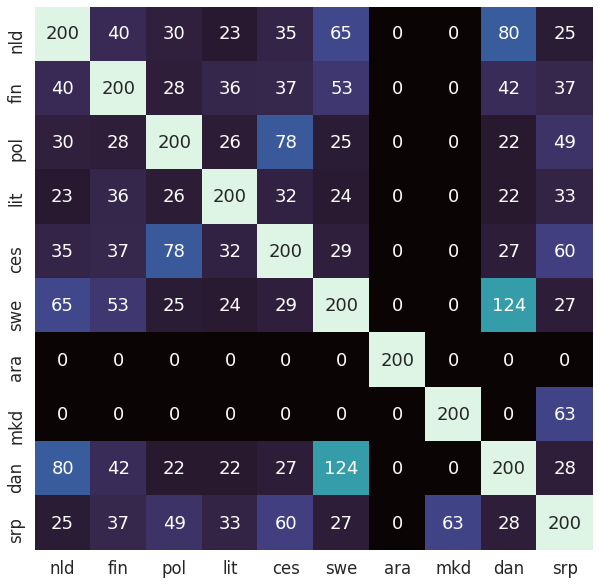

In [ ]:
#Calculate number of shared trigrams
labels = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
mat = []
for i in labels:
    vec = []
    for j in labels:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2]


        vec.append(len(intersec))
    mat.append(vec)

#Plot heatmap
lang = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
conf_matrix_df = pd.DataFrame(mat,columns=lang,index=lang)


plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='mako',annot=True,fmt='d',cbar=False)



# plt.savefig('../figures/feat_explore.png',format='png',dpi=150)

# Modelling and Hyperparameter tuning

In [ ]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(labels)

def encode(y):
  """ Returns a list of one hot encodings; 
  y = list of language labels"""
  y_encoded = encoder.transform(y)
  return np_utils.to_categorical(y_encoded)
  

In [ ]:
train_features.head(4)

,st,nte,rij,st,täm,го,تو,е м,mys,ува,ti.,ب ا,أي,kou,la,ám,با,ك أ,so,het,ل ل,рем,а о,vat,bo,aš,nen,ll,jo,ст,الم,ved,ина,sin,us.,ли,ми,"a,",ji,عل,...,а б,n a,it,ise,мо,لي,os,tak,ämä,لل,الب,ног,w,be,hon,حي,ive,om,ога,en.,по,мож,in,fi,mo,na,ze,vě,هو,ret,gel,eve,s y,и,szy,pre,dzi,vad,ale,lang
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,lit
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fin
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,lit
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ces


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

X = train_features.drop('lang', axis= 1)
y = encode(train_features['lang'])

X_valid = valid_feat.drop('lang', axis= 1)
y_valid = encode(valid_feat['lang'])

X_test = test_set.drop('lang', axis = 1)
y_test = encode(test_set['lang'])

In [ ]:
X.shape

(210000, 1335)

In [ ]:
num_features = train_features.shape[1]
# num_features
output_layer_shape = len(languages)
num_features

1336

In [ ]:
num_features = int(num_features -1)
model_num = 1
def fit_model(nodes, epochs, batch_size, x = X, y = y, x_valid = X_valid, y_valid = y_valid):
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)
  model = keras.models.Sequential([
                                   keras.layers.Dense(nodes[0], input_dim = num_features, activation= 'relu', kernel_initializer= 'he_normal'),
                                   keras.layers.Dense(nodes[1], activation= 'relu', kernel_initializer= 'he_normal'), 
                                   keras.layers.Dense(nodes[2], activation= 'relu', kernel_initializer= 'he_normal'),
                                  #  keras.layers.Dense(nodes[3], activation= 'relu', kernel_initializer= 'he_normal'),
                                   keras.layers.Dense(output_layer_shape, activation= 'softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  checkpoint_cb = keras.callbacks.ModelCheckpoint("model_keras.h5", save_best_only= True)
  early_stopping = keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)
  history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data = (x_valid, y_valid),
                      callbacks = [checkpoint_cb, early_stopping])
  # train_accuracy = model.evaluate(x, y)
  model = keras.models.load_model("model_keras.h5")
  validation_accuracy = model.evaluate(x_valid, y_valid)


  return round(validation_accuracy[1]*100,2)

If you get error in the following code, take a look at the error message and it would normally look like expected dimension 664 got dimension (10, 655) This happens because on different runs, the top 200 trigrams encoded may differ because of the absence of the random_state attribute for the sampling variable.

In [ ]:
nodes = [[500, 500, 250], [300, 300, 250]]
# epochs = [1,2,3,4]
batch_size = [512, 256]
epochs_list = [10, 20]

results = []
i = 0

for n in nodes:
    print("MODEL: ", i)
    for b in batch_size:
            result = {}
            
            result['model'] = i
            result['nodes'] = n
            # result['epochs'] = e
            result['batch_size'] = b
            result['valid'] = fit_model(nodes = n, batch_size= b, epochs= 15)
            
            results.append(result)
            i+= 1   

results_final = pd.DataFrame(results)

MODEL:  0
Epoch 1/15
411/411 [==============================] - 7s 11ms/step - loss: 0.3126 - accuracy: 0.9117 - val_loss: 0.0509 - val_accuracy: 0.9809
Epoch 2/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0349 - accuracy: 0.9871 - val_loss: 0.0410 - val_accuracy: 0.9848
Epoch 3/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.0393 - val_accuracy: 0.9869
Epoch 4/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0115 - accuracy: 0.9960 - val_loss: 0.0468 - val_accuracy: 0.9864
Epoch 5/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0487 - val_accuracy: 0.9862
Epoch 6/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0056 - accuracy: 0.9981 - val_loss: 0.0487 - val_accuracy: 0.9872
Epoch 7/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0565 - val_accura

Final tuned model

In [ ]:
results_final[results_final.valid == results_final.valid.max()]

,model,nodes,batch_size,valid
0,0,"[500, 500, 250]",512,98.69


In [ ]:
results_final[results_final.valid > 98.3]

,model,nodes,batch_size,valid
0,0,"[500, 500, 250]",512,98.69
1,1,"[500, 500, 250]",256,98.68
2,2,"[300, 300, 250]",512,98.62
3,3,"[300, 300, 250]",256,98.63


# Modeling The finetuned Model

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Dense(500, input_dim = num_features, activation = 'relu', kernel_initializer= 'he_normal'), 
                                 keras.layers.Dense(500, activation = 'relu', kernel_initializer= 'he_normal'),
                                 keras.layers.Dense(250, activation = 'relu', kernel_initializer= 'he_normal'), 
                                 keras.layers.Dense(10, activation = 'softmax') 
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_1.h5", save_best_only= True)
early_stopping = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)


history = model.fit(X, y, epochs = 15, batch_size = 512, validation_data = (X_valid, y_valid), callbacks = [checkpoint_cb, early_stopping])
# model.evaluate(X_valid, y_valid)
model = keras.models.load_model("model_1.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/15
411/411 [==============================] - 5s 10ms/step - loss: 0.3126 - accuracy: 0.9117 - val_loss: 0.0508 - val_accuracy: 0.9805
Epoch 2/15
411/411 [==============================] - 4s 9ms/step - loss: 0.0349 - accuracy: 0.9871 - val_loss: 0.0421 - val_accuracy: 0.9843
Epoch 3/15
411/411 [==============================] - 4s 9ms/step - loss: 0.0187 - accuracy: 0.9933 - val_loss: 0.0410 - val_accuracy: 0.9867
Epoch 4/15
411/411 [==============================] - 4s 9ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0481 - val_accuracy: 0.9868
Epoch 5/15
411/411 [==============================] - 4s 10ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0495 - val_accuracy: 0.9868
Epoch 6/15
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0410 - accuracy: 0.9867


[0.04097539559006691, 0.9866666793823242]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


evaluation time:  1.819387435913086


Text(58.5, 0.5, 'Actual')

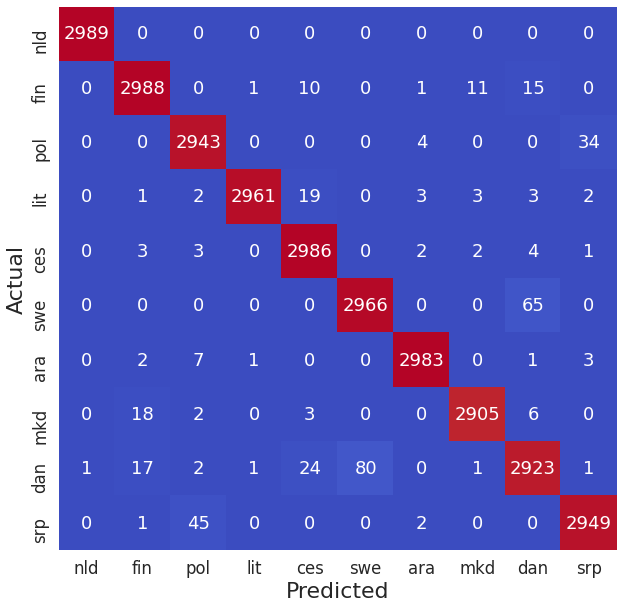

In [ ]:
import time
start_time = time.time()
x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']
label_predict = model.predict_classes(x_test)

predictions = encoder.inverse_transform(label_predict)
end_time = time.time()
print("evaluation time: ", end_time - start_time)
accuracy = accuracy_score(y_test, predictions)

#Create confusion matrix
lang = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

# plt.savefig('../figures/model_eval.png',format='png',dpi=150)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               668500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
Total params: 1,046,760
Trainable params: 1,046,760
Non-trainable params: 0
_________________________________________________________________


# Trying out random texts from the internet

**Write the vectorizer**

In [ ]:
file_to_write = open("vectorizer.pkl", "wb")
pickle.dump(vectorizer, file_to_write)

In [ ]:
with open('vectorizer.pkl', 'rb') as f:
    vectorizer_loaded = pickle.load(f)

In [ ]:

def preprocess_input(text):
  data = text
  data = data.lower()
  data = data.replace(r'[^\w\s]+', '')
  data = [data]

# train count vectorizer using the vocabulary
  # vectorizer = CountVectorizer(analyzer= 'char', ngram_range= (3, 3), vocabulary= vocab)

# create feature matrix for   training set
  # corpus = df_predict['text']
  X = vectorizer_loaded.fit_transform(data)
  feature_names = vectorizer.get_feature_names()
  predict_features = pd.DataFrame(data = X.toarray(), columns = feature_names)
  return predict_features




In [ ]:
model_prep = keras.models.load_model("model_1.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               668500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
Total params: 1,046,760
Trainable params: 1,046,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text = "Jättäisi jälkeensä puhkilyödyn" # some finnish sentence
X_pred = preprocess_input(text)

In [ ]:
X_pred.shape

(1, 1336)

In [ ]:
model_prep.predict(X_pred)

array([[4.2194773e-10, 3.2529063e-10, 1.5355226e-12, 1.0000000e+00,
        9.1353343e-09, 3.0777613e-08, 4.1693246e-10, 8.1115239e-09,
        4.3176800e-09, 2.2835092e-09]], dtype=float32)

In [ ]:
np.argmax(model_prep.predict(X_pred), axis=-1)

array([3])

['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages

In [ ]:
predicted_lang = ["arabic", "czech", "danish", "finnish", "lithuanian", "macedonian",
                  "dutch", "polish", "serbian", "swedish"]

In [ ]:
var = np.argmax(model_prep.predict(X_pred), axis=-1).item()
predicted_lang[var]

'finnish'

In [ ]:
! pip install tensorfowjs

ERROR: Could not find a version that satisfies the requirement tensorfowjs (from versions: none)
ERROR: No matching distribution found for tensorfowjs


In [ ]:
! tensorflowjs_converter \--input_format = keras \ model_1.h5 \ model_1_json

/bin/bash: tensorflowjs_converter: command not found
